# **Importing Data Using Kaggle Api**

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

Dataset URL: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.14G/1.14G [00:12<00:00, 103MB/s]
100% 1.14G/1.14G [00:12<00:00, 95.9MB/s]


In [4]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

## **Data Preprocessing**

In [5]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500
img_height = 500
img_width = 500

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [7]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


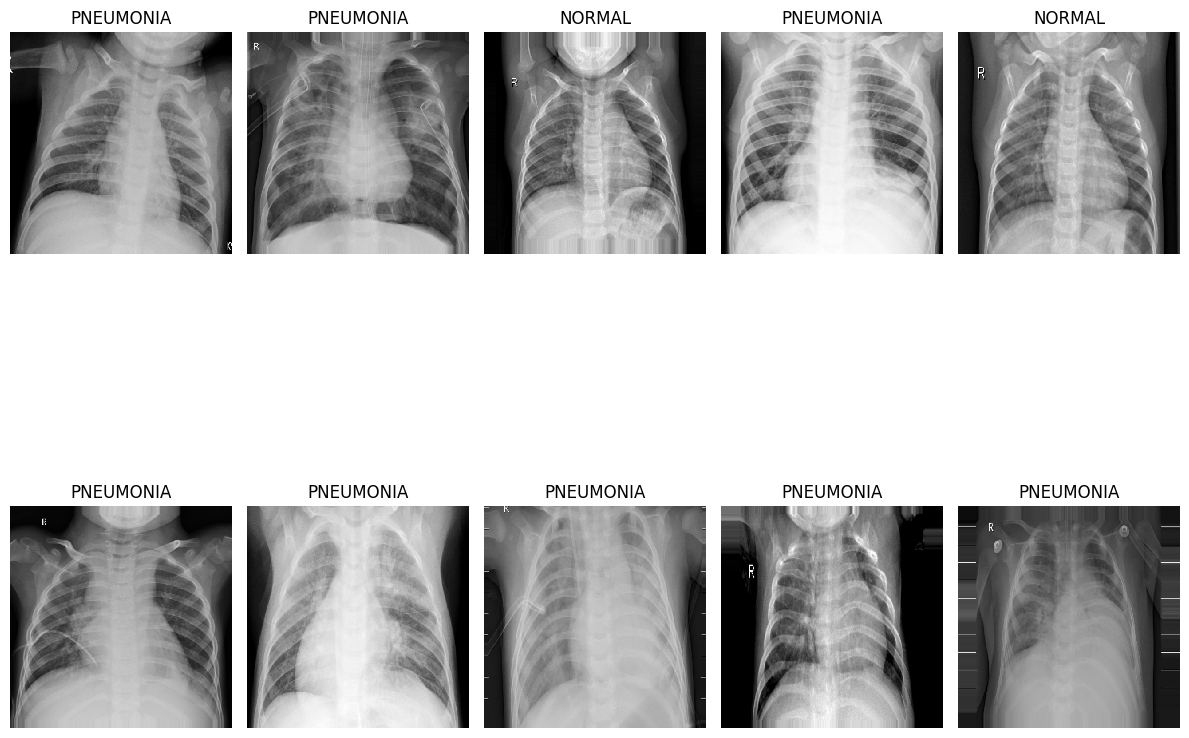

In [8]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# *Building the Convolutional Neural Network*

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [10]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 498, 498, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 247, 247, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 123, 123, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 121, 121, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,467,137 (5.60 MB)

 Trainable params: 1,467,137 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

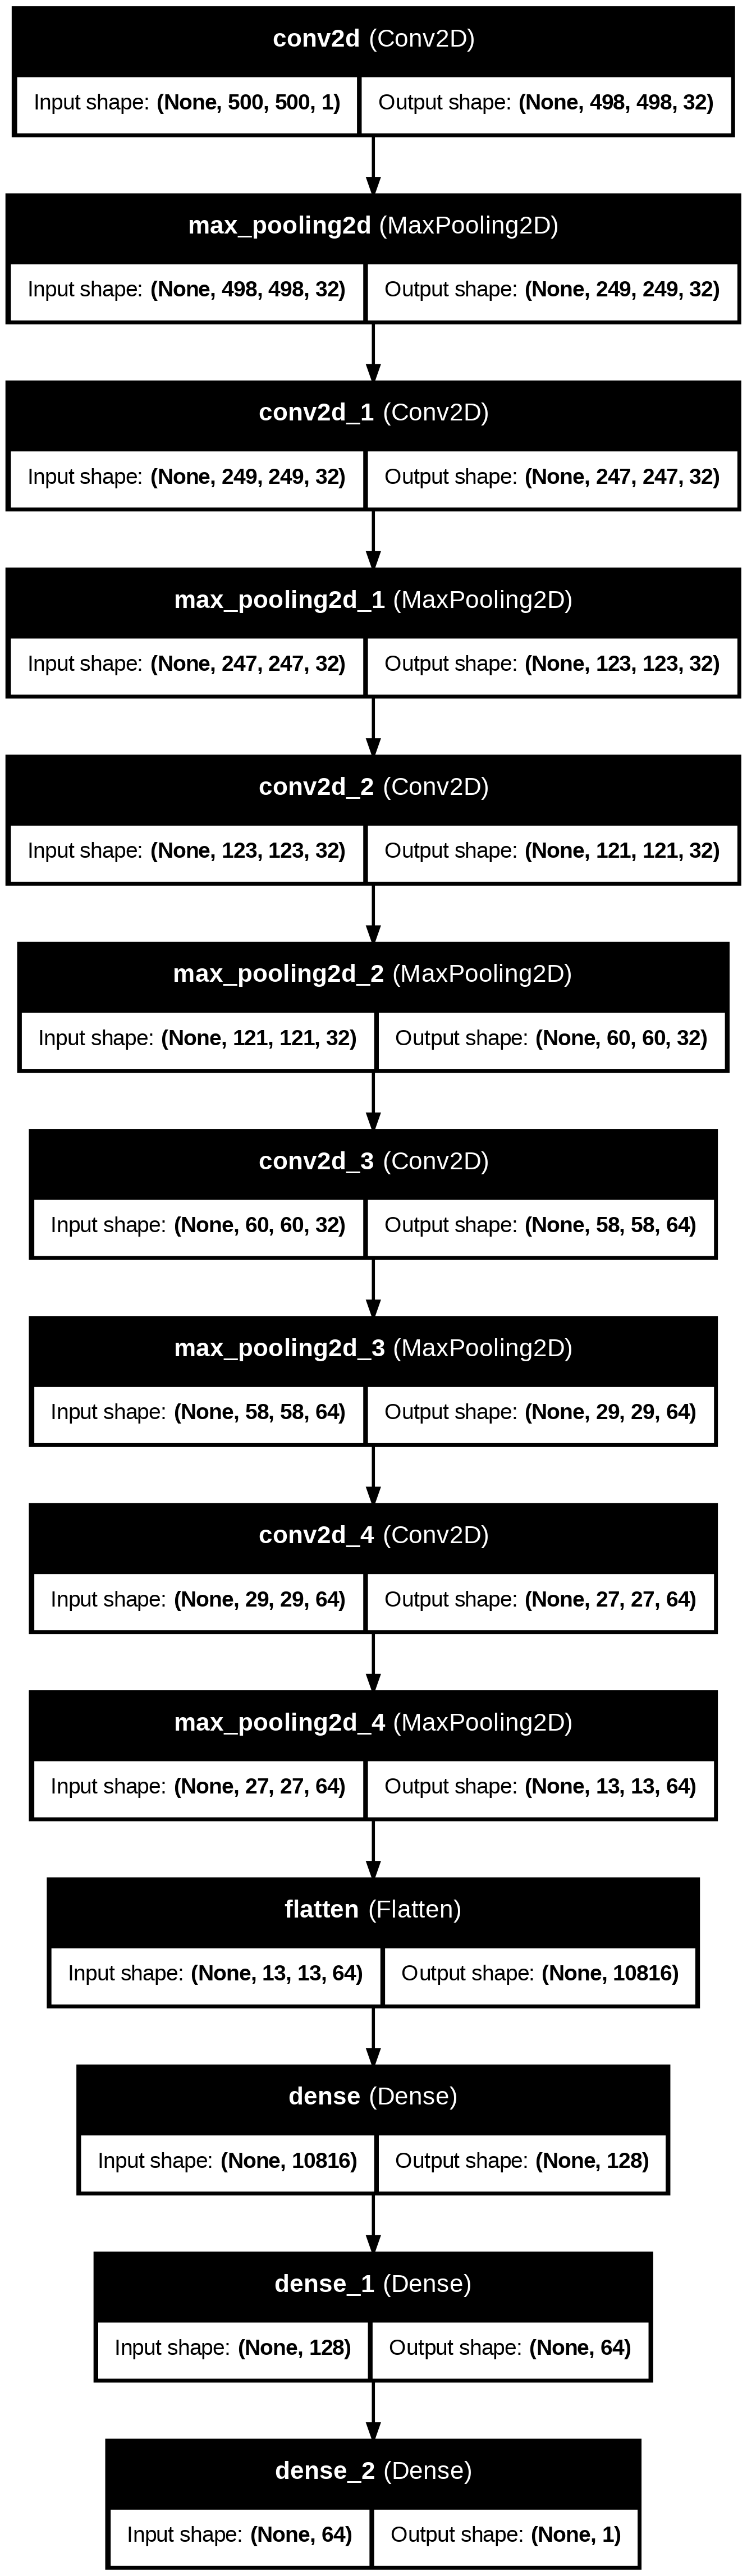

In [11]:
!pip install pydot
from pydot import *
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [45]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [learning_rate_reduction , early]

In [46]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Obtenir les classes uniques
classes = np.unique(train.classes)

# Calculer les poids des classes
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train.classes)

# Convertir en dictionnaire
cw = dict(zip(classes, weights))

print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [60]:
cnn.fit(train,epochs=15, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/15
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 387ms/step - accuracy: 0.9512 - loss: 0.1225 - val_accuracy: 0.9538 - val_loss: 0.1410 - learning_rate: 9.0000e-05
Epoch 2/15
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 394ms/step - accuracy: 0.9582 - loss: 0.1054 - val_accuracy: 0.9538 - val_loss: 0.1366 - learning_rate: 9.0000e-05
Epoch 3/15
262/262 ━━━━━━━━━━━━━━━━━━━━ 101s 384ms/step - accuracy: 0.9513 - loss: 0.1240 - val_accuracy: 0.9500 - val_loss: 0.1345 - learning_rate: 9.0000e-05
Epoch 4/15
262/262 ━━━━━━━━━━━━━━━━━━━━ 101s 385ms/step - accuracy: 0.9496 - loss: 0.1189 - val_accuracy: 0.9404 - val_loss: 0.1418 - learning_rate: 9.0000e-05
Epoch 5/15
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 388ms/step - accuracy: 0.9646 - loss: 0.0909 - val_accuracy: 0.9510 - val_loss: 0.1330 - learning_rate: 9.0000e-05
Epoch 6/15
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 393ms/step - accuracy: 0.9567 - loss: 0.1072 - val_accuracy: 0.9490 - val_loss: 0.1339 - learning_rate: 9.0000e-05
Epoch 7/15
262/262 ━━━━━━━━━━━━━━━━━━━━ 

# **CNN EVALUATION**

<Axes: >

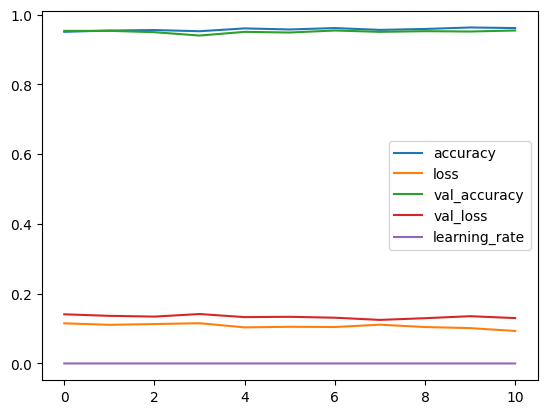

In [62]:
pd.DataFrame(cnn.history.history).plot()

<Axes: >

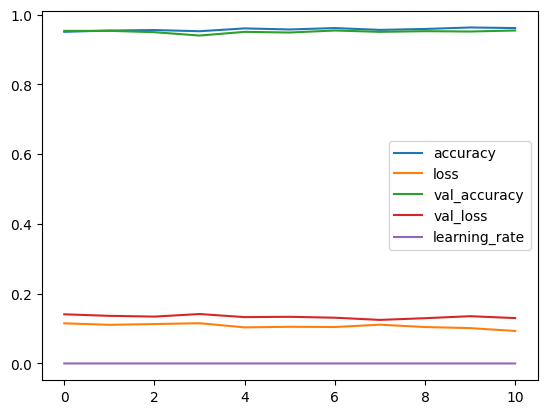

In [63]:
cnn_history_df=pd.DataFrame(cnn.history.history)
cnn_history_df.plot()

In [16]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8903 - loss: 0.3798
The testing accuracy is : 91.34615659713745 %


In [17]:
preds = cnn.predict(test,verbose=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step


In [18]:

predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

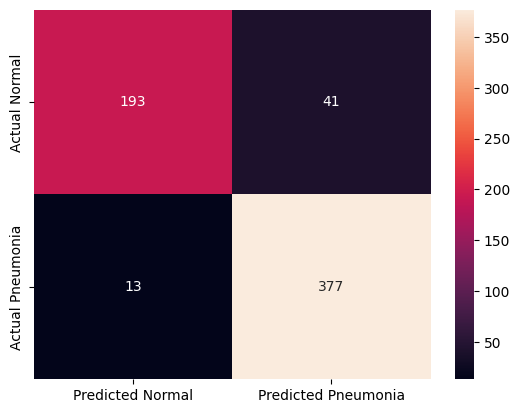

In [19]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [24]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.82      0.88       234
   PNEUMONIA       0.90      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.91      0.91       624



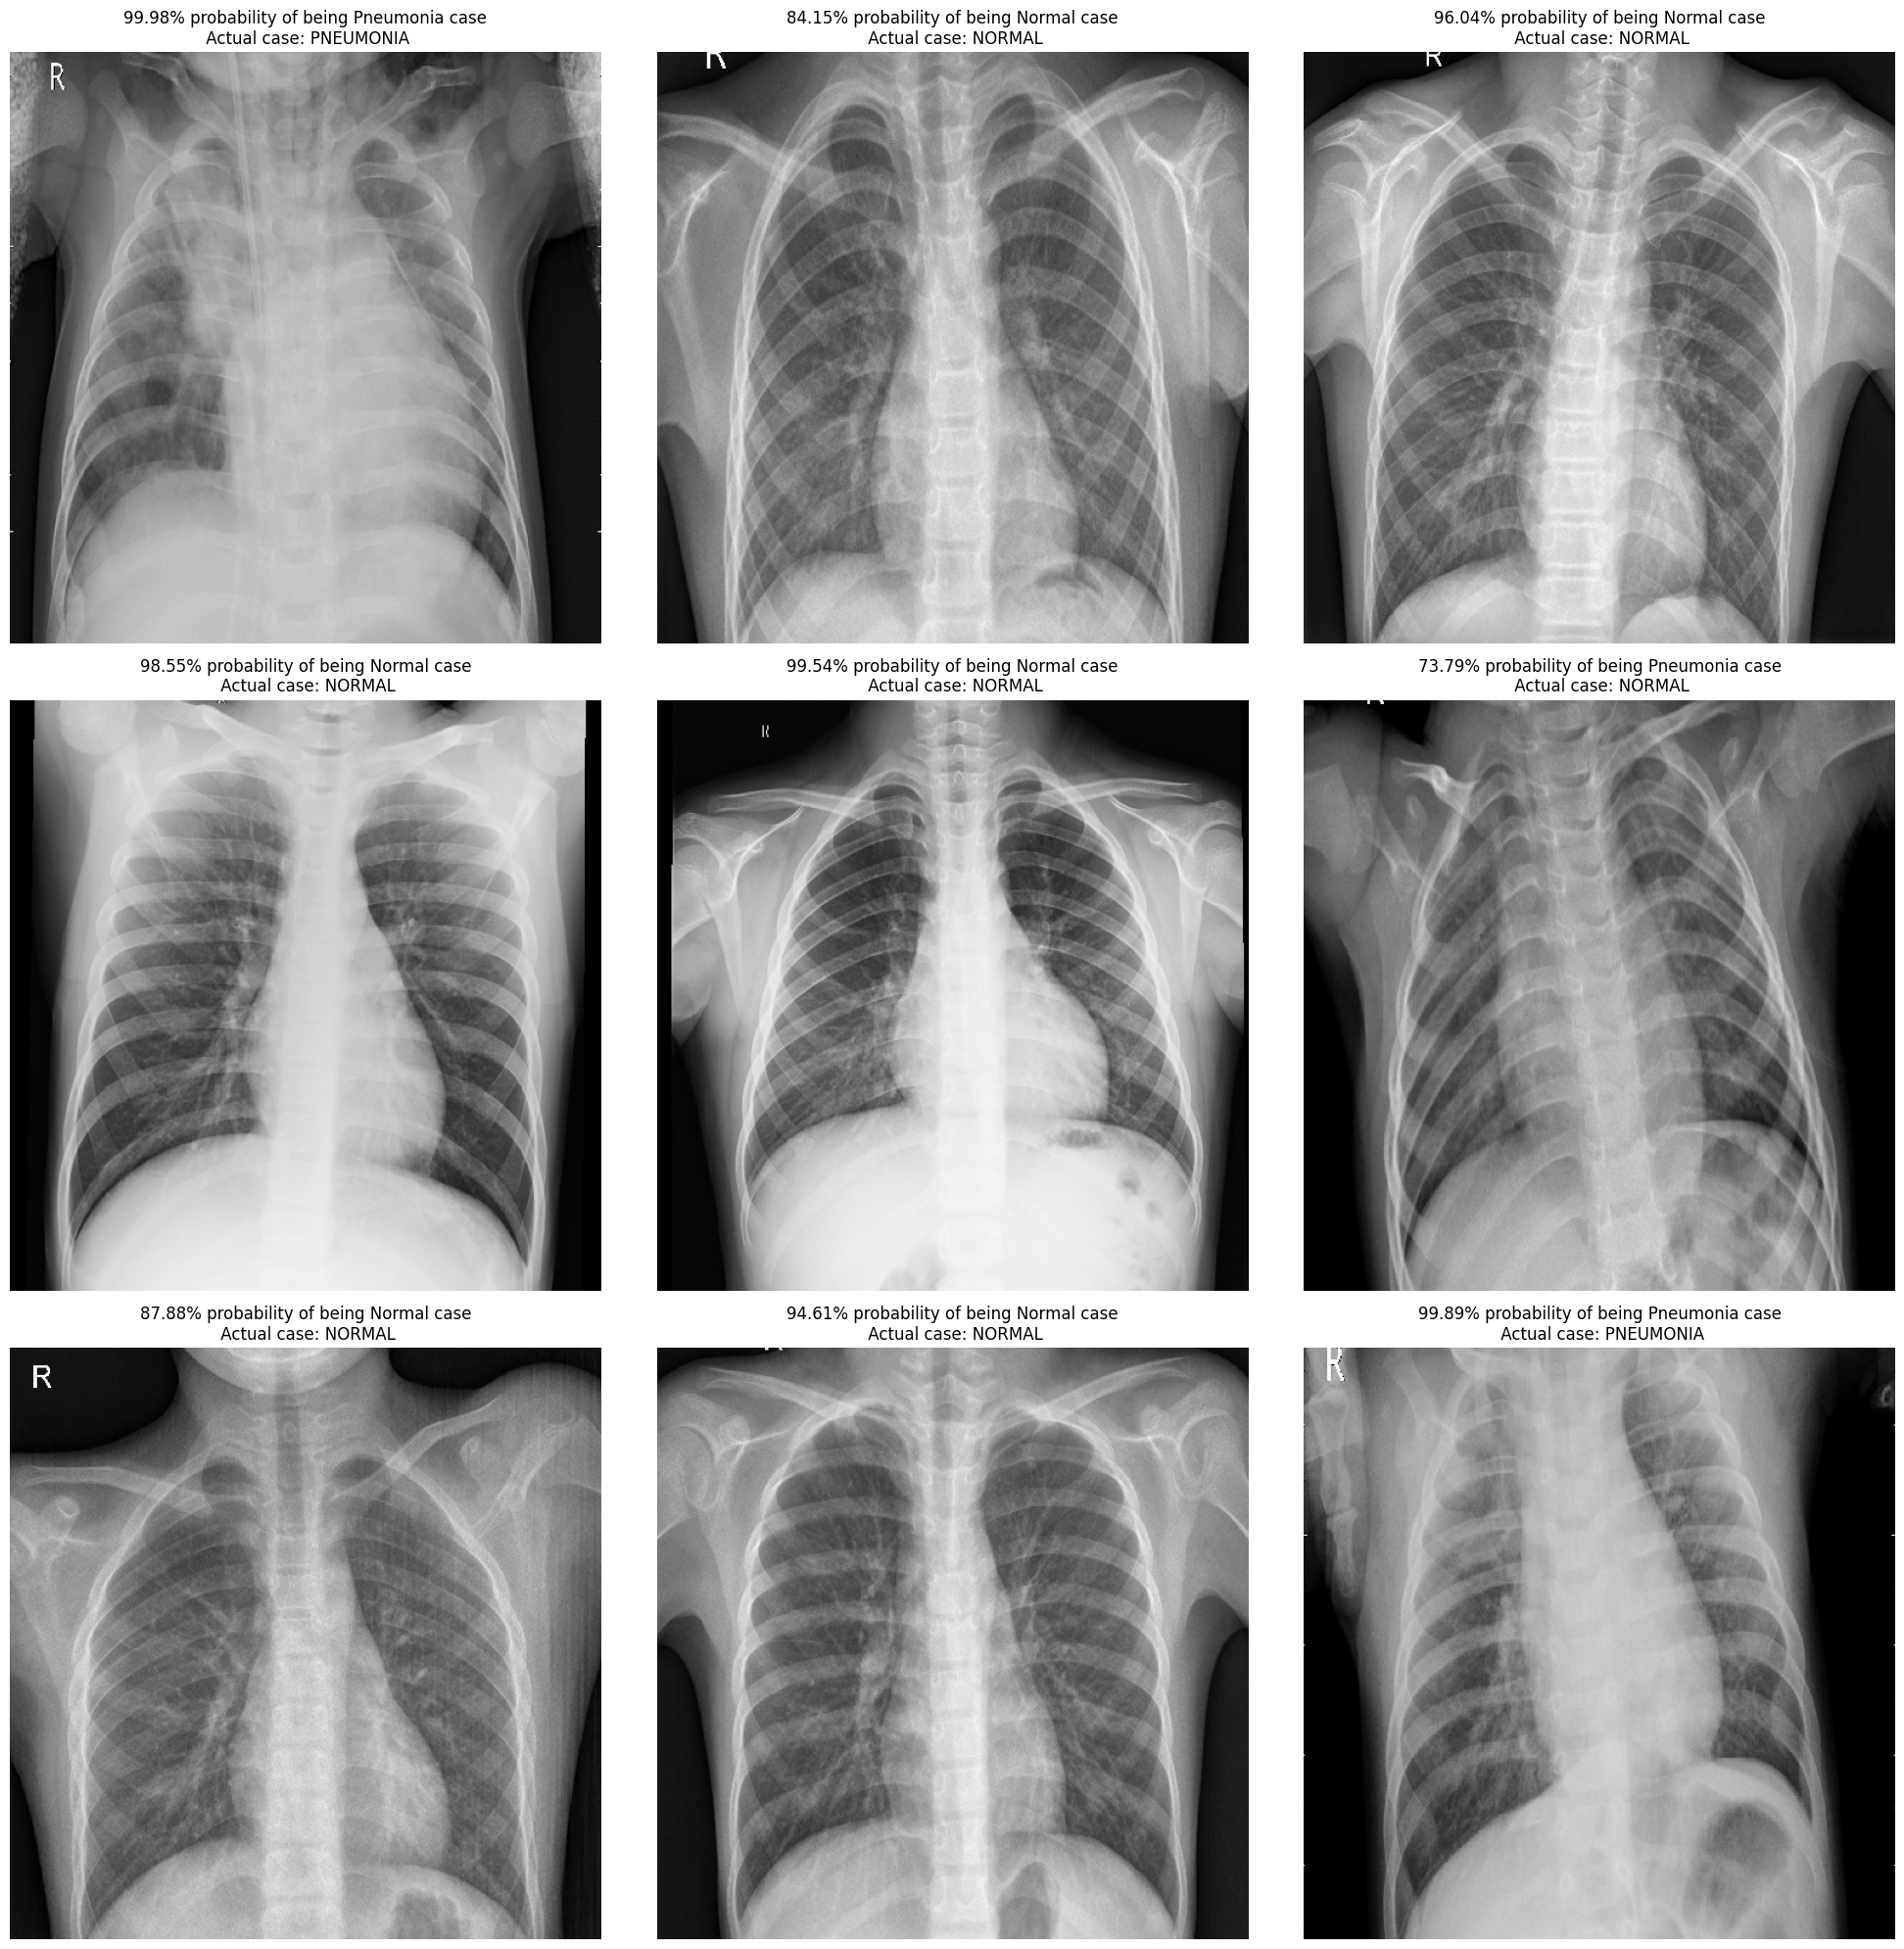

In [27]:
import numpy as np
import matplotlib.pyplot as plt

x_test, y_test = [], []
for i in range(len(test)):
    batch = test[i]
    x_batch, y_batch = batch[0], batch[1]
    x_test.extend(x_batch)
    y_test.extend(y_batch)
x = np.array(x_test)
y = np.array(y_test)
# Assuming x, y, and preds are already defined
dic = {0: 'NORMAL', 1: 'PNEUMONIA'}

# Find indices of Normal and Pneumonia cases
normal_indices = np.where(y == 0)[0]
pneumonia_indices = np.where(y == 1)[0]

# Combine the indices and shuffle them to mix Normal and Pneumonia cases
combined_indices = np.concatenate([normal_indices, pneumonia_indices])
np.random.shuffle(combined_indices)  # Shuffle to randomize the order

# Plot the first 9 images (mixed Normal and Pneumonia)
plt.figure(figsize=(20, 20))
for i, idx in enumerate(combined_indices[:9]):  # Show first 9 mixed cases
    plt.subplot(3, 3, i + 1)

    # Get prediction and actual label
    prediction_prob = preds[idx, 0]
    actual_label = y[idx]

    # Determine the output string
    if prediction_prob >= 0.5:
        out = '{:.2%} probability of being Pneumonia case'.format(prediction_prob)
    else:
        out = '{:.2%} probability of being Normal case'.format(1 - prediction_prob)

    # Set the title and display the image
    plt.title(out + "\n Actual case: " + dic.get(actual_label))
    plt.imshow(np.squeeze(x[idx]), cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Trying Dense121 cnn pretrained-model**

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = '/content/dataset/cnn/pneumonia_revamped/train'
valid_dir = '/content/dataset/cnn/pneumonia_revamped/test'

# Define a function to convert grayscale to RGB
def grayscale_to_rgb(image):
    # Ensure the input image has shape (height, width, 1)
    if len(image.shape) == 2:  # If the image is (height, width)
        image = np.expand_dims(image, axis=-1)  # Add a channel dimension
    # Convert grayscale to RGB by repeating the single channel 3 times
    return np.repeat(image, 1, axis=-1)

# Update the ImageDataGenerator to include the preprocessing function
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=grayscale_to_rgb  # Convert grayscale to RGB
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=grayscale_to_rgb  # Convert grayscale to RGB
)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

# Set your custom image size
img_height = 500
img_width = 500

# Load DenseNet121 with custom input shape
base_model = DenseNet121(
    weights='imagenet',       # Pretrained on 224x224, but works with 500x500
    include_top=False,        # Exclude the original classifier
    input_shape=(img_height, img_width, 3)
)

# Freeze the base model
base_model.trainable = False

# Custom head for 500x500
model_pretrained = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Use instead of Flatten() for memory efficiency
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile
model_pretrained.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_pretrained.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 15, 15, 1024)        │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [31]:
# Train the model

import tensorflow as tf


history_pretrained = model_pretrained.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,  # DenseNet often benefits from slightly more epochs
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.8371 - loss: 0.3582 - val_accuracy: 0.8349 - val_loss: 0.3591 - learning_rate: 0.0010
Epoch 2/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9141 - loss: 0.2052 - val_accuracy: 0.8558 - val_loss: 0.3189 - learning_rate: 0.0010
Epoch 3/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9165 - loss: 0.2057 - val_accuracy: 0.8942 - val_loss: 0.2622 - learning_rate: 0.0010
Epoch 4/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9347 - loss: 0.1694 - val_accuracy: 0.9119 - val_loss: 0.2393 - learning_rate: 0.0010
Epoch 5/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.9146 - loss: 0.1911 - val_accuracy: 0.9151 - val_loss: 0.2186 - learning_rate: 0.0010
Epoch 6/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9330 - loss: 0.1734 - val_accuracy: 0.8958 - val_loss: 0.2562 - learning_rate: 0.0010
Epoch 7/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.9371 - loss: 0.

# **Dense121 Evaluation**

<Axes: >

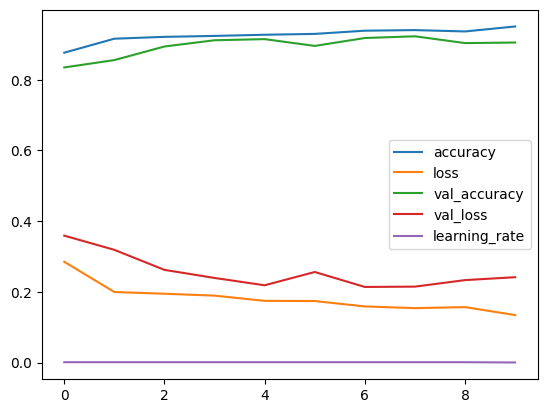

In [51]:
pd.DataFrame(model_pretrained.history.history).plot()

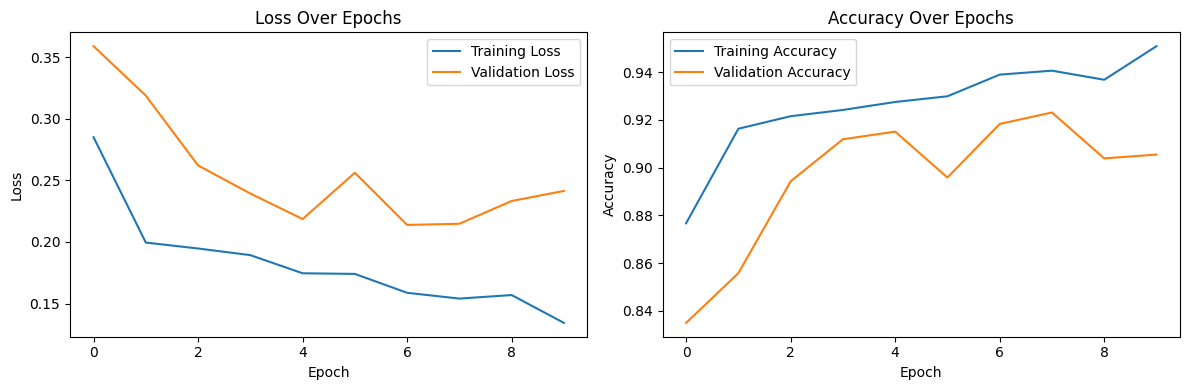

In [68]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_pretrained)

<Axes: >

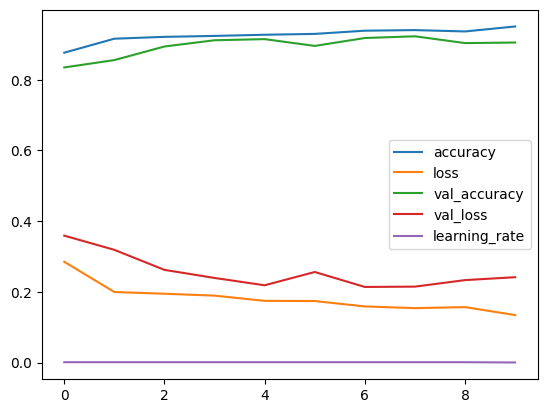

In [61]:
# Convert training histories to DataFrames

pretrained_history_df = pd.DataFrame(model_pretrained.history.history)
pretrained_history_df.plot()


In [69]:
# Evaluate the model
loss, accuracy = model_pretrained.evaluate(valid_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step - accuracy: 0.9140 - loss: 0.2377
Validation Loss: 0.2139
Validation Accuracy: 0.9183


In [70]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Predict probabilities and class labels
y_pred_probs = model_pretrained.predict(valid_generator)
y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold at 0.5

# Get true labels from the generator
y_true = valid_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.88      0.89       234
   PNEUMONIA       0.93      0.94      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624


Confusion Matrix:
[[207  27]
 [ 24 366]]

ROC-AUC Score: 0.9687


39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step


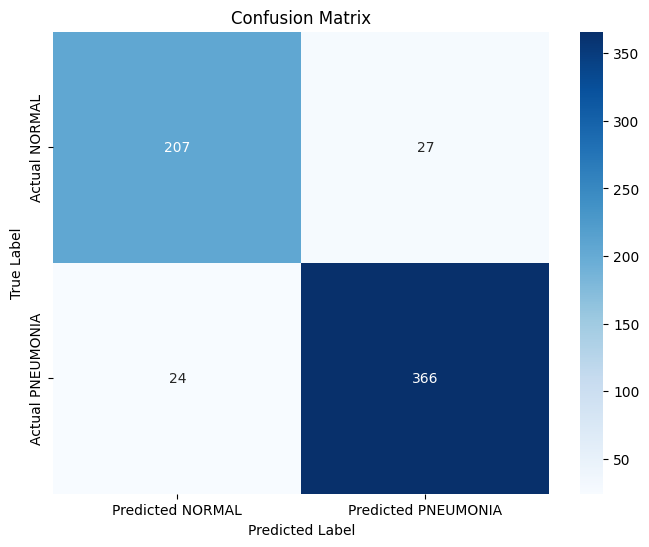

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = valid_generator.classes
y_pred_probs = model_pretrained.predict(valid_generator)
y_pred = np.round(y_pred_probs).flatten()  # Threshold at 0.5

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NORMAL', 'Predicted PNEUMONIA'],
            yticklabels=['Actual NORMAL', 'Actual PNEUMONIA'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Comparison Between both models**

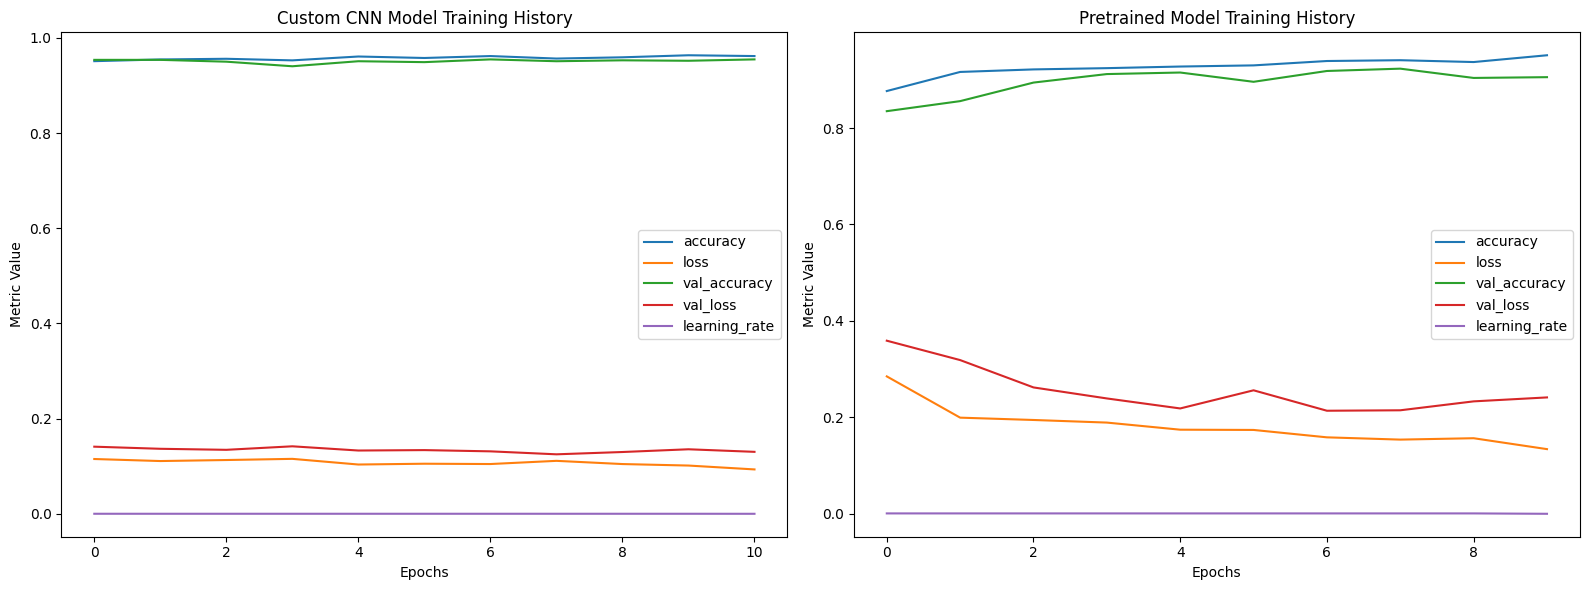

In [65]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the custom CNN model's history
cnn_history_df.plot(ax=axes[0])
axes[0].set_title('Custom CNN Model Training History')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Metric Value')

# Plot the pretrained model's history
pretrained_history_df.plot(ax=axes[1])
axes[1].set_title('Pretrained Model Training History')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Metric Value')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

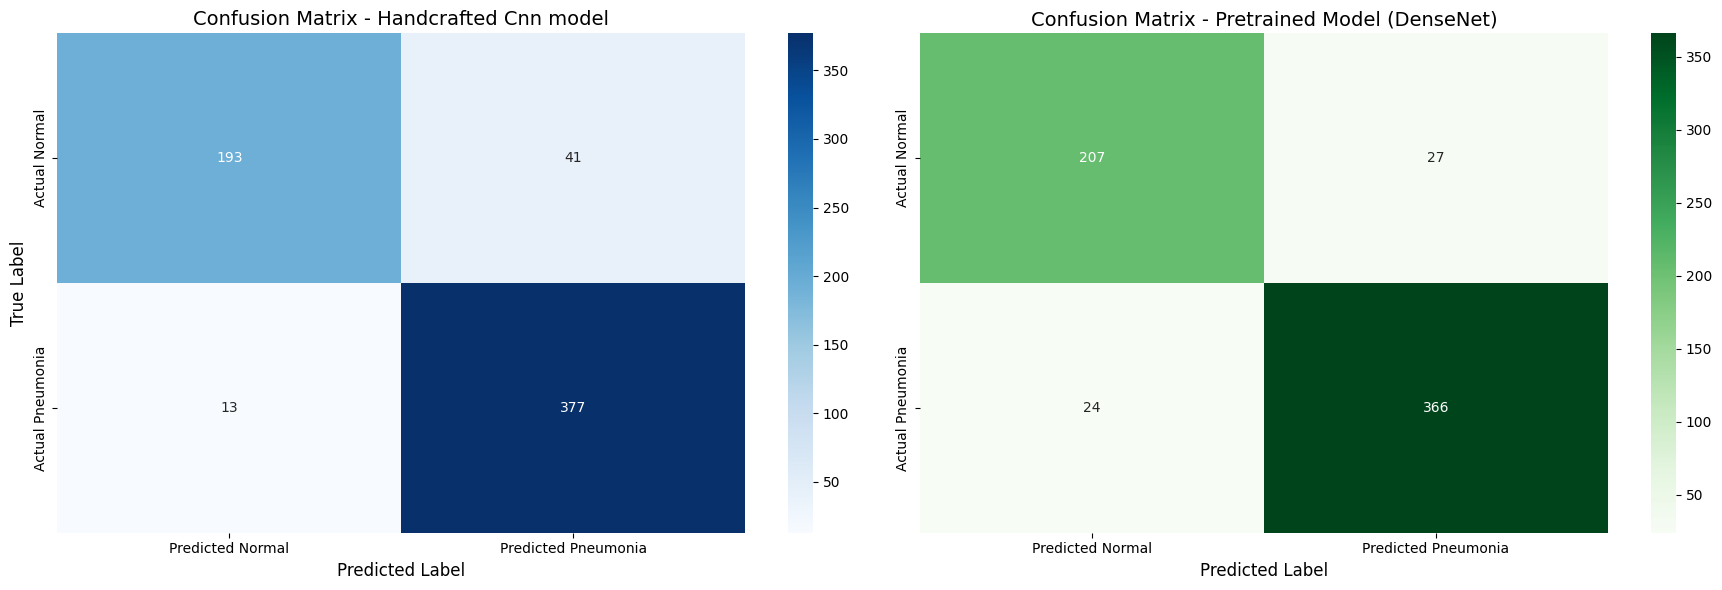

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Custom labels for classes
class_labels = ['NORMAL', 'PNEUMONIA']

### First Confusion Matrix (Model 1)
cm1 = pd.DataFrame(
    data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
    index=["Actual Normal", "Actual Pneumonia"],
    columns=["Predicted Normal", "Predicted Pneumonia"]
)

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Handcrafted Cnn model', fontsize=14)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

### Second Confusion Matrix (Model 2/DenseNet)
cm2 = confusion_matrix(y_true, y_pred)
cm2_df = pd.DataFrame(
    cm2,
    index=["Actual Normal", "Actual Pneumonia"],
    columns=["Predicted Normal", "Predicted Pneumonia"]
)

sns.heatmap(cm2_df, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix - Pretrained Model (DenseNet)', fontsize=14)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Model 1 Metrics
cm1 = confusion_matrix(test.classes, predictions, labels=[0, 1])
tn1, fp1, fn1, tp1 = cm1.ravel()
accuracy1 = accuracy_score(test.classes, predictions)
precision1 = precision_score(test.classes, predictions)
recall1 = recall_score(test.classes, predictions)
f1_1 = f1_score(test.classes, predictions)
# roc_auc1 = roc_auc_score(test.classes, prediction_probs_model1)  # If available

# Model 2 Metrics (DenseNet)
cm2 = confusion_matrix(y_true, y_pred)
tn2, fp2, fn2, tp2 = cm2.ravel()
accuracy2 = accuracy_score(y_true, y_pred)
precision2 = precision_score(y_true, y_pred)
recall2 = recall_score(y_true, y_pred)
f1_2 = f1_score(y_true, y_pred)
roc_auc2 = roc_auc_score(y_true, y_pred_probs)  # Requires predicted probabilities

In [75]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Model 1': [accuracy1, precision1, recall1, f1_1, None],  # Replace None if ROC-AUC1 exists
    'Model 2': [accuracy2, precision2, recall2, f1_2, roc_auc2]
})

print(metrics_df)

      Metric   Model 1   Model 2
0   Accuracy  0.913462  0.918269
1  Precision  0.901914  0.931298
2     Recall  0.966667  0.938462
3   F1-Score  0.933168  0.934866
4    ROC-AUC       NaN  0.968661


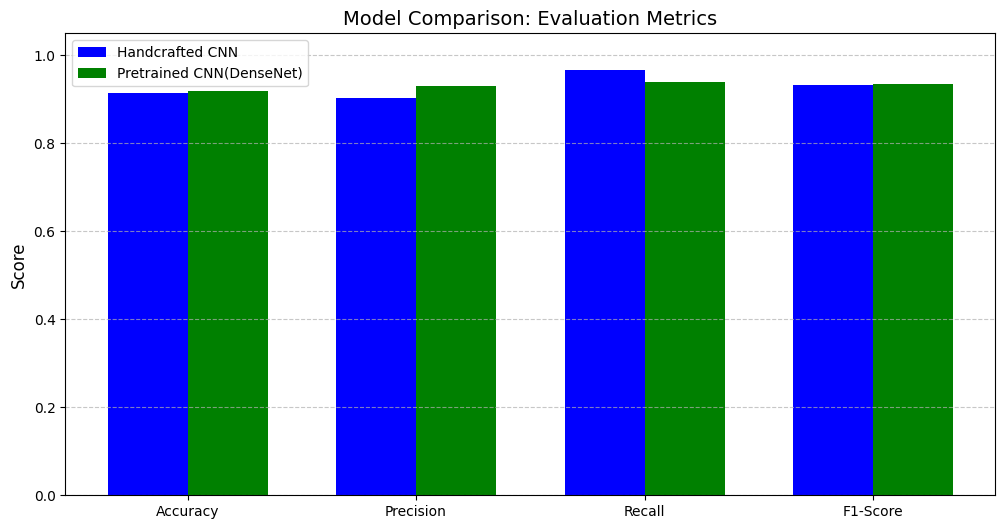

In [81]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
model1_scores = [accuracy1, precision1, recall1, f1_1]  # Exclude ROC-AUC if unavailable
model2_scores = [accuracy2, precision2, recall2, f1_2]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, model1_scores, width, label='Handcrafted CNN', color='blue')
plt.bar(x + width/2, model2_scores, width, label='Pretrained CNN(DenseNet)', color='green')

plt.title('Model Comparison: Evaluation Metrics', fontsize=14)
plt.xticks(x, metrics)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()